# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply scenario discovery

1. Generate 10 policies and 1000 scenarios and evaluate them.
2. The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: use `experiments.drop`*
3. Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

In [4]:
from ema_workbench import Policy, perform_experiments, MultiprocessingEvaluator
from ema_workbench import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 1000
n_policies = 10
results = perform_experiments(lake_model, n_scenarios, n_policies)

[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished


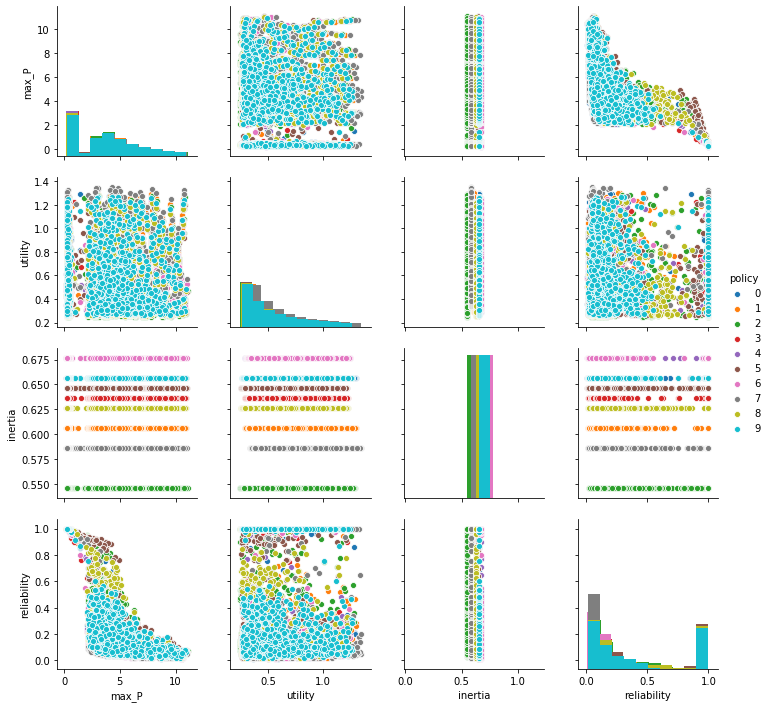

In [5]:
experiments, outcomes = results
policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

sns.pairplot(data, hue='policy', vars=outcomes.keys(), diag_kind='hist')
plt.show()

## Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

In [6]:
levers = ['l' + str(i) for i in range(100)]
exp = experiments.drop(['policy', 'model', 'scenario'], axis=1)
exp = exp.drop(levers, axis=1)

In [7]:
import numpy as np

In [8]:
y = outcomes["reliability"] < np.percentile(outcomes["reliability"], 10)

In [63]:
from ema_workbench.analysis import prim
from ema_workbench.util import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

x = exp

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.03) 

In [64]:
box1 = prim_alg.find_box()

[MainProcess/INFO] 10000 points remaining, containing 999 cases of interest
[MainProcess/INFO] mean: 0.926, mass: 0.05, coverage: 0.46346346346346345, density: 0.926 restricted_dimensions: 4


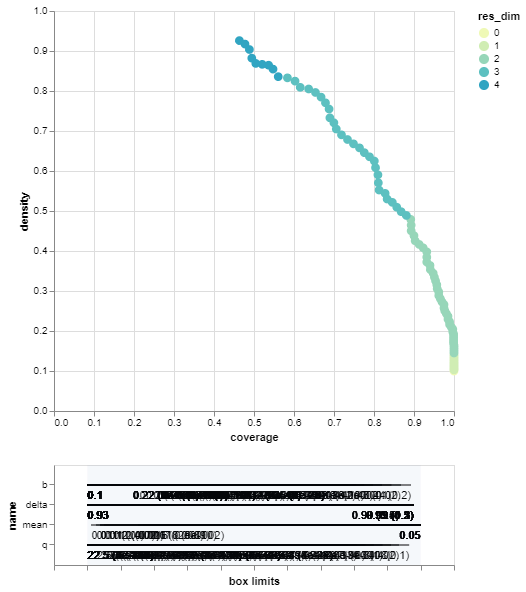

In [65]:
box1.inspect_tradeoff()

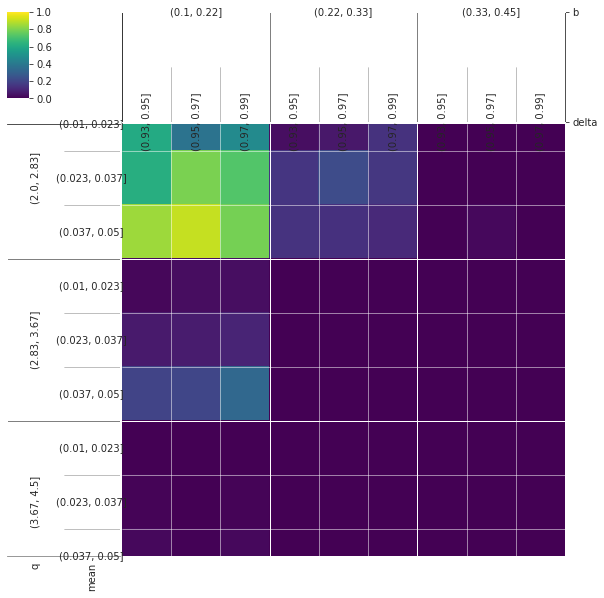

In [50]:
from ema_workbench.analysis import dimensional_stacking

dimensional_stacking.create_pivot_plot(exp[['b', 'q', 'mean', 'delta']], y, nr_levels=2, nbins=3, bin_labels = True)
plt.show()

#### Conclusions

- The maximum cases seem to be when the value of delta is in the second bin, the value of mean is in the last bin, b and q are in the first bin. 
- In general, the most cases are when b and q are in the first bin, with mean in the last one
- A probable future imporvement would be to use feature scoring to decide which 4 variables are used on the higher and lower axes of dimension stacking
- It can be seen that box no 82 of the prim scenario discovery matches with the dimension stacking. This is the first box where the uncertainty 'mean' in peeled. However, prim allows for narrowing down even further on the mean axis. 

##### Questions/Clarifications

- Unable to peel the 5th dimension (Std Dev) using PRIM. What is it we're missing out on?
- Only certain values of peel alpha allows for 4 dimensions to be restricted. Any other value of peel alpha restrict mostly 3 dimensions and rarely all 5 unless the threshold is reduced drastically. Is this because the values of mean and std dev are smaller than the other uncertainties?